# How to work with larget JSON datasets using Python and Pandas 
## March 18, 2016

Working with large JSON datasets can be a pain, particularly when they are too large to fit into memory. In cases like this, a combination of command line tools and Python can make for an efficient way to explore and analyze the data. In this post, we’ll look at how to leverage tools like Pandas to explore and map out police activity in Montgomery County, Maryland. We’ll start with a look at the JSON data, then segue into exploration and analysis.



#### Based upon this website https://www.dataquest.io/blog/using-json-data-in-pandas/

## The dataset

We’ll be looking at a dataset that contains information on traffic violations in Montgomery County, Maryland. You can download the data [here](https://catalog.data.gov/dataset/traffic-violations-56dda). The data contains information about where the violation happened, the type of car, demographics on the person receiving the violation, and some other interesting information. 

There are quite a few questions we could answer using this dataset, including:

* What types of cars are most likely to be pulled over for speeding?
* What times of day are police most active?
* How common are “speed traps”? Or are tickets spread pretty evenly in terms of geography?
* What are the most common things people are pulled over for?

Unfortunately, we don’t know the structure of the JSON file upfront, so we’ll need to do some exploration to figure it out. We’ll use [Jupyter Notebook](http://jupyter.org/) for this exploration.

The data has been downloaded to a location on the edge node: /san-data/shared/public/traffic/

## Exploring the data

Even though the JSON file is only 600 MB, we’ll treat it like it’s much larger so we can explore how analyzing a JSON file that doesn’t fit into memory might work. The first thing we’ll do is take a look at the first few lines of the md_traffic.json file. A JSON file is just an ordinary text file, so we can use all the standard command line tools to interact with it:

In [1]:
import os

In [2]:
traffic_dir = '/san-data/shared/public/traffic/'
os.chdir(traffic_dir)

In [3]:
!head md_traffic.json


{
  "meta" : {
    "view" : {
      "id" : "4mse-ku6q",
      "name" : "Traffic Violations",
      "averageRating" : 0,
      "category" : "Public Safety",
      "createdAt" : 1403103517,
      "description" : "This dataset contains traffic violation information from all electronic traffic violations issued in the County.  Any information that can be used to uniquely identify the vehicle, the vehicle owner or the officer issuing the violation will not be published.\r\n\r\nUpdate Frequency:  Daily",
      "displayType" : "table",


From this, we can tell that the JSON data is a dictionary, and is well formatted.  `meta` is a top level key, and is indented two spaces. We can get all of the top level keys by using the [`grep`](https://en.wikipedia.org/wiki/Grep) command to print any lines that have two leading spaces:

In [4]:
%%bash
grep -E '^ {2}"' md_traffic.json

#!grep -E '^ {2}"' md_traffic.json

  "meta" : {
  "data" : [ [ 1895928, "25D4FF9D-842D-4B43-8F68-2CB6C6CBA4D6", 1895928, 1456999986, "498050", 1456999986, "498050", null, "2016-03-02T00:00:00", "23:19:00", "MCP", "3rd district, Silver Spring", "FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAMPS, ILLUMINATING DEVICE IN UNFAVORABLE VISIBILITY COND", "CCOLESVILLE ROAD @ LANARK WAY", "-77.0140283333333", "39.0187333333333", "No", "No", "No", "No", "No", "No", "No", "No", "No", "No", "MD", "02 - Automobile", "2001", "NISS", "TK", "WHITE", "Warning", "22-201.1", "Transportation Article", "No", "BLACK", "M", "BURTONSVILLE", "MD", "MD", "A - Marked Patrol", [ "{\"address\":\"\",\"city\":\"\",\"state\":\"\",\"zip\":\"\"}", "-77.0140283333333", "39.0187333333333", null, false ] ]


This shows us that `meta` and `data` are top level keys in the `md_traffic.json data`. A list of lists appears to be associated with data, and this likely contains each record in our traffic violations dataset. Each inner list is a record, and the first record appears in the output from the `grep` command. This is very similar to the kind of structured data we’re used to working with when we operate on CSV files or SQL tables. Here’s a truncated view of how the data might look:
> [

>   [1889194, "92AD0076-5308-45D0-BDE3-6A3A55AD9A04", 1889194, 1455876689, "498050"],

>    [1889194, "92AD0076-5308-45D0-BDE3-6A3A55AD9A04", 1889194, 1455876689, "498050"],

>    ...

> ]

This looks a lot like the rows and columns that we’re used to working with. We’re just missing the headers that tell us what each column means. We may be able to find this information under the `meta` key.

`meta` usually refers to information about the data itself. Let’s dig a little more into `meta` and see what information is contained there. From the head command, we know that there are at least `3` levels of keys, with `meta` containing a key `view`, which contains the keys `id`, `name`, `averageRating` and others. We can print out the full key structure of the JSON file by using grep to print out any lines with 2-6 leading spaces:


In [5]:
%%bash
grep -E '^ {2,6}"' md_traffic.json

  "meta" : {
    "view" : {
      "id" : "4mse-ku6q",
      "name" : "Traffic Violations",
      "averageRating" : 0,
      "category" : "Public Safety",
      "createdAt" : 1403103517,
      "description" : "This dataset contains traffic violation information from all electronic traffic violations issued in the County.  Any information that can be used to uniquely identify the vehicle, the vehicle owner or the officer issuing the violation will not be published.\r\n\r\nUpdate Frequency:  Daily",
      "displayType" : "table",
      "downloadCount" : 3082,
      "iconUrl" : "fileId:r41tDc239M1FL75LFwXFKzFCWqr8mzMeMTYXiA24USM",
      "indexUpdatedAt" : 1457000588,
      "newBackend" : false,
      "numberOfComments" : 0,
      "oid" : 8890705,
      "publicationAppendEnabled" : false,
      "publicationDate" : 1411040702,
      "publicationGroup" : 1620779,
      "publicationStage" : "published",
      "rowClass" : "",
      "rowsUpdatedAt" : 1456999991,
      "rowsUpdatedBy" : "ajn4-zy

This shows us the full key structure associated with `md_traffic.json`, and tell us which parts of the JSON file are relevant for us. In this case, the `columns` key looks interesting, as it potentially contains information on the columns in the list of lists in the `data` key.

## Extracting information on the columns

Now that we know which key contains information on the columns, we need to read that information in. Because we’re assuming that the JSON file won’t fit in memory, we can’t just directly read it in using the [json](https://docs.python.org/3/library/json.html) library. Instead, we’ll need to iteratively read it in in a memory-efficient way.

We can accomplish this using the [ijson](https://pypi.python.org/pypi/ijson/) package. ijson will iteratively parse the json file instead of reading it all in at once. This is slower than directly reading the whole file in, but it enables us to work with large files that can’t fit in memory. To use ijson, we specify a file we want to extract data from, then we specify a key path to extract:

In [6]:
import ijson


filename = "md_traffic.json"
with open(filename, 'r') as f:
    objects = ijson.items(f, 'meta.view.columns.item')
    columns = list(objects)

In the above code, we open the `md_traffic.json file`, then we use the `items` method in ijson to extract a list from the file. We specify the path to the list using the `meta.view.columns` notation. Recall that `meta` is a top level key, which contains `view` inside, which contains columns inside it. We then specify `meta.view.columns.item` to indicate that we should extract each individual item in the `meta.view.columns` list. The items function will return a [generator](https://wiki.python.org/moin/Generators), so we use the list method to turn the generator into a Python list. We can print out the first item in the list:

In [7]:
print(columns[0])

{'id': -1, 'position': 0, 'format': {}, 'fieldName': ':sid', 'dataTypeName': 'meta_data', 'name': 'sid', 'renderTypeName': 'meta_data'}


From the above output, it looks like each item in `columns` is a dictionary that contains information about each column. In order to get our header, it looks like `fieldName` is the relevant key to extract. To get our column names, we just have to extract the `fieldName` key from each item in `columns`:

In [8]:
column_names = [col["fieldName"] for col in columns]
column_names

[':sid',
 ':id',
 ':position',
 ':created_at',
 ':created_meta',
 ':updated_at',
 ':updated_meta',
 ':meta',
 'date_of_stop',
 'time_of_stop',
 'agency',
 'subagency',
 'description',
 'location',
 'latitude',
 'longitude',
 'accident',
 'belts',
 'personal_injury',
 'property_damage',
 'fatal',
 'commercial_license',
 'hazmat',
 'commercial_vehicle',
 'alcohol',
 'work_zone',
 'state',
 'vehicle_type',
 'year',
 'make',
 'model',
 'color',
 'violation_type',
 'charge',
 'article',
 'contributed_to_accident',
 'race',
 'gender',
 'driver_city',
 'driver_state',
 'dl_state',
 'arrest_type',
 'geolocation']

Great! Now that we have our columns names, we can move to extracting the data itself.

## Extracting the data

You may recall that the data is locked away in a _list of lists_ inside the `data` key. We’ll need to read this data into memory to manipulate it. Fortunately, we can use the column names we just extracted to only grab the columns that are relevant. This will save a ton of space. If the dataset was larger, you could iteratively process batches of rows. So read in the first 10000000 rows, do some processing, then the next 10000000, and so on. In this case, we can define the columns we care about, and again use ijson to iteratively process the JSON file:

In [9]:
good_columns = [
    "date_of_stop", 
    "time_of_stop", 
    "agency", 
    "subagency",
    "description",
    "location", 
    "latitude", 
    "longitude", 
    "vehicle_type", 
    "year", 
    "make", 
    "model", 
    "color", 
    "violation_type",
    "race", 
    "gender", 
    "driver_state", 
    "driver_city", 
    "dl_state",
    "arrest_type"
]

data = []
with open(filename, 'r') as f:
    objects = ijson.items(f, 'data.item')
    for row in objects:
        selected_row = []
        for item in good_columns:
            selected_row.append(row[column_names.index(item)])
        data.append(selected_row)

Now that we’ve read the data in, we can print out the first item in `data`:

In [10]:
data[0]

['2016-03-02T00:00:00',
 '23:19:00',
 'MCP',
 '3rd district, Silver Spring',
 'FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAMPS, ILLUMINATING DEVICE IN UNFAVORABLE VISIBILITY COND',
 'CCOLESVILLE ROAD @ LANARK WAY',
 '-77.0140283333333',
 '39.0187333333333',
 '02 - Automobile',
 '2001',
 'NISS',
 'TK',
 'WHITE',
 'Warning',
 'BLACK',
 'M',
 'MD',
 'BURTONSVILLE',
 'MD',
 'A - Marked Patrol']

## Reading the data into Pandas
Now that we have the data as a _list of lists_, and the column headers as a _list_, we can create a Pandas Dataframe to analyze the data. If you’re unfamiliar with Pandas, it’s a data analysis library that uses an efficient, tabular data structure called a Dataframe to represent your data. Pandas allows you to convert a list of lists into a Dataframe and specify the column names separately.


In [11]:
len(data)

834925

In [12]:
import pandas as pd
stops = pd.DataFrame(data, columns=good_columns)

Now that we have our data in a Dataframe we can do some interesting analysis. Here is a table of how many stops are made by car color:

In [13]:
stops["color"].value_counts()

BLACK          162519
SILVER         151804
WHITE          123760
GRAY            87094
RED             66693
BLUE            62240
GREEN           35995
GOLD            28024
TAN             18975
BLUE, DARK      17525
MAROON          15213
BLUE, LIGHT     11678
BEIGE           10583
GREEN, DK       10418
N/A              9631
GREEN, LGT       5239
BROWN            4070
YELLOW           3240
ORANGE           2990
BRONZE           1985
PURPLE           1727
MULTICOLOR        724
CREAM             608
COPPER            269
PINK              137
CHROME             21
CAMOUFLAGE         17
Name: color, dtype: int64

Here is a table of what kind of  police unit created the citation:

In [14]:
stops["arrest_type"].value_counts()

A - Marked Patrol                         676089
Q - Marked Laser                           88456
B - Unmarked Patrol                        25643
S - License Plate Recognition              11492
O - Foot Patrol                             9613
L - Motorcycle                              8575
E - Marked Stationary Radar                 4915
R - Unmarked Laser                          4355
G - Marked Moving Radar (Stationary)        2210
M - Marked (Off-Duty)                       1307
I - Marked Moving Radar (Moving)             863
F - Unmarked Stationary Radar                428
C - Marked VASCAR                            323
D - Unmarked VASCAR                          212
P - Mounted Patrol                           175
N - Unmarked (Off-Duty)                      116
H - Unmarked Moving Radar (Stationary)        72
K - Aircraft Assist                           41
J - Unmarked Moving Radar (Moving)            40
Name: arrest_type, dtype: int64

With the rise of red light cameras and speed lasers, it's interesting that patrol cars are still by far the dominant source of citations.

## Converting columns
We’re now almost ready to do some time and location based analysis, but we need to convert the `longitude`, `latitude`, and `date` columns from strings to floats first. We can use the below code to convert `latitude` and `longitude`:

In [17]:
stops['longitude'].describe()

count        761300
unique       297020
top       39.045425
freq            374
Name: longitude, dtype: object

In [23]:
import numpy as np


In [22]:
## look at what is causing the longitude to dump out
def parse_float_a(x):
    try:
        x = np.float(x)
    except TypeError:
        print(x)
        x = np.nan
    return x

In [26]:
stops['long'] = stops.longitude.apply(parse_float_a)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [27]:
stops.long.isnull().sum()

73625

In [28]:
stops.long.describe()

count    761300.000000
mean        -64.111497
std          36.628312
min         -94.610988
25%         -77.178253
50%         -77.077210
75%         -77.012772
max          77.187162
Name: long, dtype: float64

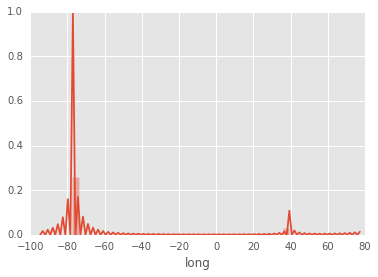

In [33]:
import seaborn as sns
sns.distplot(stops[~stops.long.isnull()].long)

In [34]:
stops[(stops.long < 20) & (stops.long>-20)]

date_of_stop time_of_stop agency              subagency  \
699767  2012-11-24T00:00:00     21:59:00    MCP  4th district, Wheaton   

                                              description  \
699767  FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAM...   

                           location   latitude          longitude  \
699767  VEIRSMILL RD AT PARKLAND DR  39.064435  0.583333333333333   

                 vehicle_type  year    ...    model color violation_type  \
699767  05 - Light Duty Truck  2004    ...      SUV  GRAY        Warning   

         race gender driver_state driver_city dl_state        arrest_type  \
699767  WHITE      M           MD     POTOMAC       MD  A - Marked Patrol   

            long  
699767  0.583333  

[1 rows x 21 columns]

In [24]:
import numpy as np

def parse_float(x):
    try:
        x = float(x)
    except Exception:
        x = 0
    return x
stops["longitude"] = stops["longitude"].apply(parse_float)
stops["latitude"] = stops["latitude"].apply(parse_float)

In [25]:
stops[['date_of_stop','time_of_stop']].head()

date_of_stop time_of_stop
0  2016-03-02T00:00:00     23:19:00
1  2016-03-02T00:00:00     00:02:00
2  2016-03-02T00:00:00     00:25:00
3  2016-03-02T00:00:00     23:28:00
4  2016-03-02T00:00:00     15:41:00

Oddly enough, time of day and the date of the stop are stored in two separate columns, `time_of_stop`, and `date_of_stop`. We’ll parse both, and turn them into a single datetime column:

In [26]:
import datetime as dt
def parse_full_date(row):
    date = dt.datetime.strptime(row["date_of_stop"], "%Y-%m-%dT%H:%M:%S")
    time = row["time_of_stop"].split(":")
    date = date.replace(hour=int(time[0]), minute = int(time[1]), second = int(time[2]))
    return date

stops["date"] = stops.apply(parse_full_date, axis=1)

We can now plot which days result in the most traffic stops

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


In [30]:
days_of_the_week = ['Mon','Tue','Wed','Thr','Fri','Sat','Sun']

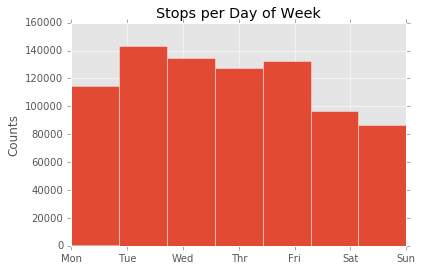

In [32]:
ax = stops.date.dt.weekday.hist(bins=7)
ax.set_xticklabels(days_of_the_week)
plt.title('Stops per Day of Week')
plt.ylabel('Counts')

Distribution of stops by hour of the day

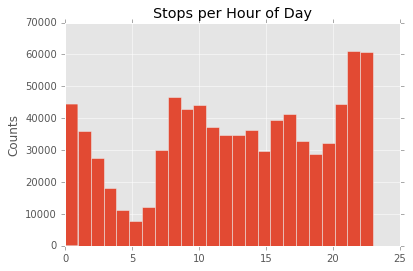

In [33]:
hour_of_day = np.arange(0,24)
stops.date.dt.hour.hist(bins=24)
plt.title('Stops per Hour of Day')
plt.ylabel('Counts')

It looks like the most stops happen around midnight, and the fewest happen around 5am. This might make sense, as people are driving home from bars and dinners late and night, and may be impaired.

## Subsetting the stops

Now that we've converted the location and date columns, we can map out the traffic stops. Because mapping is very intensive in terms of CPU resources and memory, we’ll need to filter down the rows we use from `stops` first:

In [35]:
last_year = stops[stops['date']> dt.datetime(year=2015,month=3,day=3)]

In [36]:
len(last_year)

233833

Now filter to morning rush and weekday

In [37]:
weekday_morning_rush = last_year[(last_year.date.dt.weekday<5)&(last_year.date.dt.hour < 10)]
print(weekday_morning_rush.shape)


(56367, 21)


Using the excellent folium package, we can now visualize where all the stops occurred. Folium allows you to easily create interactive maps in Python by leveraging leaflet. In order to preserve performance, we’ll only visualize the first 1000 rows of morning_rush:

In [50]:
import folium
from folium import plugins

stops_map = folium.Map(location=[39.0836, -77.1483], zoom_start=11)
marker_cluster = folium.MarkerCluster().add_to(stops_map)
#for name, row in weekday_morning_rush.iloc[:1000].iterrows():
for name, row in weekday_morning_rush.iloc[:5000].iterrows():
    folium.Marker([row["longitude"], row["latitude"]], popup=row["description"]).add_to(marker_cluster)
stops_map.create_map('stops.html')
stops_map

/san-data/shared/python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [40]:
stops_heatmap = folium.Map(location=[39.0836, -77.1483], zoom_start=11)
stops_heatmap.add_children(plugins.HeatMap([[row["longitude"], row["latitude"]] for name, row in weekday_morning_rush.iloc[:1000].iterrows()]))
stops_heatmap.save("heatmap.html")
stops_heatmap

## Conclusion

In this post, we learned how to go from raw JSON data to fully functional maps using command line tools, ijson, Pandas, matplotlib, and folium. 

If you want to further explore this dataset, here are some interesting questions to answer:
* Does the type of stop vary by location?
* How does income correlate with number of stops?
* How does population density correlate with number of stops?
* What types of stops are most common around midnight?

In [52]:
#ch_map =folium.Map(location=[39.496898, -76.641810], zoom_start=11)
#ch_map.save('ch.html')
#ch_map

# Now for some of my investigations
* many of these 'incidents/stops' are duplicates; in otherwords a given stop may involve multiple warnings/citations.

### Deduplicate these; make sure Date, lat+long, and vehicle match

In [55]:
#[my_descript for my_descript in weekday_morning_rush.iloc[:5000].description if my_descript ==  'DRIVING VEH. W/O ADEQUATE REAR REG. PLATE ILLUMINATION']
[my_descript for my_descript in weekday_morning_rush.iloc[:5000].description if my_descript ==  'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY']

['CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY',
 'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY',
 'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY',
 'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY',
 'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY',
 'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY']

In [56]:
weekday_morning_rush.iloc[:5000][weekday_morning_rush.iloc[:5000].description == 'CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PASSAGE OF ROADWAY']

date_of_stop time_of_stop agency                    subagency  \
1637   2016-02-29T00:00:00     02:25:00    MCP  3rd district, Silver Spring   
2770   2016-02-23T00:00:00     08:41:00    MCP  3rd district, Silver Spring   
3672   2016-02-22T00:00:00     09:02:00    MCP  3rd district, Silver Spring   
7464   2016-02-17T00:00:00     06:18:00    MCP        4th district, Wheaton   
13237  2016-02-08T00:00:00     04:35:00    MCP       2nd district, Bethesda   
19335  2016-01-29T00:00:00     01:34:00    MCP  3rd district, Silver Spring   

                                             description  \
1637   CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   
2770   CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   
3672   CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   
7464   CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   
13237  CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   
19335  CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   

                                  location   latitude  longitude  \
1637    E/B BRIGGS CHANEY RD @ CASTLE BLVD -76.939492  39.073498   
2770       NICHOLSON LANE @ ROCKVILLE PIKE -77.110367  39.041392   
3672            SECOND AVE. @ GEORGIA AVE. -77.027283  38.994307   
7464             ASPEN HILL RD/ORIENTAL ST -77.093920  39.074922   
13237      ST ELMO AVE @ OLD GEORGETOWN RD -77.098570  38.987663   
19335  UNIVERSITY BLVD E @ PINEY BRANCH RD -76.995438  38.999945   

          vehicle_type  year         ...              model   color  \
1637   02 - Automobile  2004         ...          NAVIGATOR    BLUE   
2770   02 - Automobile  2006         ...               750K   BLACK   
3672   02 - Automobile  2002         ...                 4S  SILVER   
7464        28 - Other  2012         ...            EXPRESS   WHITE   
13237   04 - Limousine  2015         ...           SUBURBAN   BLACK   
19335  02 - Automobile  2005         ...              E-250   WHITE   

      violation_type      race gender driver_state    driver_city dl_state  \
1637         Warning     BLACK      M           MD    GLEN BURNIE       MD   
2770        Citation     WHITE      F           MD     GERMANTOWN       MD   
3672        Citation  HISPANIC      M           MD    HYATTSVILLE       MD   
7464        Citation  HISPANIC      M           MD  SILVER SPRING       MD   
13237        Warning     ASIAN      M           MD      ROCKVILLE       MD   
19335        Warning  HISPANIC      M           MD        ADELPHI       MD   

             arrest_type                date  
1637   A - Marked Patrol 2016-02-29 02:25:00  
2770   A - Marked Patrol 2016-02-23 08:41:00  
3672   A - Marked Patrol 2016-02-22 09:02:00  
7464   A - Marked Patrol 2016-02-17 06:18:00  
13237  A - Marked Patrol 2016-02-08 04:35:00  
19335  A - Marked Patrol 2016-01-29 01:34:00  

[6 rows x 21 columns]

In [57]:
weekday_morning_rush.iloc[:5000][weekday_morning_rush.iloc[:5000].location == 'E/B BRIGGS CHANEY RD @ CASTLE BLVD']

date_of_stop time_of_stop agency                    subagency  \
1636  2016-02-29T00:00:00     02:25:00    MCP  3rd district, Silver Spring   
1637  2016-02-29T00:00:00     02:25:00    MCP  3rd district, Silver Spring   
1739  2016-02-29T00:00:00     02:25:00    MCP  3rd district, Silver Spring   

                                            description  \
1636  DRIVING VEH. W/O ADEQUATE REAR REG. PLATE ILLU...   
1637  CAUSING STANDING VEH. TO OBSTRUCT FREE VEH. PA...   
1739                                        WINDOW TINT   

                                location   latitude  longitude  \
1636  E/B BRIGGS CHANEY RD @ CASTLE BLVD -76.939492  39.073498   
1637  E/B BRIGGS CHANEY RD @ CASTLE BLVD -76.939492  39.073498   
1739  E/B BRIGGS CHANEY RD @ CASTLE BLVD -76.939492  39.073498   

         vehicle_type  year         ...              model color  \
1636  02 - Automobile  2004         ...          NAVIGATOR  BLUE   
1637  02 - Automobile  2004         ...          NAVIGATOR  BLUE   
1739  02 - Automobile  2004         ...          NAVIGATOR  BLUE   

     violation_type   race gender driver_state  driver_city dl_state  \
1636        Warning  BLACK      M           MD  GLEN BURNIE       MD   
1637        Warning  BLACK      M           MD  GLEN BURNIE       MD   
1739          ESERO  BLACK      M           MD  GLEN BURNIE       MD   

            arrest_type                date  
1636  A - Marked Patrol 2016-02-29 02:25:00  
1637  A - Marked Patrol 2016-02-29 02:25:00  
1739  A - Marked Patrol 2016-02-29 02:25:00  

[3 rows x 21 columns]

In [58]:
same_stop_columns = ['latitude','longitude','date','year','make','model']
weekday_morning_rush.iloc[:5000][weekday_morning_rush.iloc[:5000].location == 'E/B BRIGGS CHANEY RD @ CASTLE BLVD'][same_stop_columns]

latitude  longitude                date  year     make      model
1636 -76.939492  39.073498 2016-02-29 02:25:00  2004  LINCOLN  NAVIGATOR
1637 -76.939492  39.073498 2016-02-29 02:25:00  2004  LINCOLN  NAVIGATOR
1739 -76.939492  39.073498 2016-02-29 02:25:00  2004  LINCOLN  NAVIGATOR

In [60]:
print('Originally there are {0} "stops", i.e. violations in the date range {1} to {2}'.format(len(stops),stops.date.min(),stops.date.max()))

Originally there are 834925 "stops", i.e. violations in the date range 2012-01-01 00:43:00 to 2016-03-02 23:56:00


In [62]:
dedup_stops = stops.drop_duplicates(subset=same_stop_columns).copy()
print("These correspond to {0} unique vehicle-date stops".format(len(dedup_stops)))

These correspond to 482948 unique vehicle-date stops


### Re-examine the distribution of these unique stops.

In [63]:
dedup_stops.isnull().any()

date_of_stop      False
time_of_stop      False
agency            False
subagency         False
description        True
location           True
latitude          False
longitude         False
vehicle_type      False
year               True
make               True
model              True
color              True
violation_type    False
race              False
gender            False
driver_state       True
driver_city        True
dl_state           True
arrest_type       False
date              False
dtype: bool

In [67]:
for col in stops.columns:
    print("Column {0} has {1} missing values".format(col,dedup_stops[col].isnull().sum()))

Column date_of_stop has 0 missing values
Column time_of_stop has 0 missing values
Column agency has 0 missing values
Column subagency has 0 missing values
Column description has 6 missing values
Column location has 1 missing values
Column latitude has 0 missing values
Column longitude has 0 missing values
Column vehicle_type has 0 missing values
Column year has 4848 missing values
Column make has 1 missing values
Column model has 19 missing values
Column color has 1244 missing values
Column violation_type has 0 missing values
Column race has 0 missing values
Column gender has 0 missing values
Column driver_state has 9 missing values
Column driver_city has 36 missing values
Column dl_state has 352 missing values
Column arrest_type has 0 missing values
Column date has 0 missing values


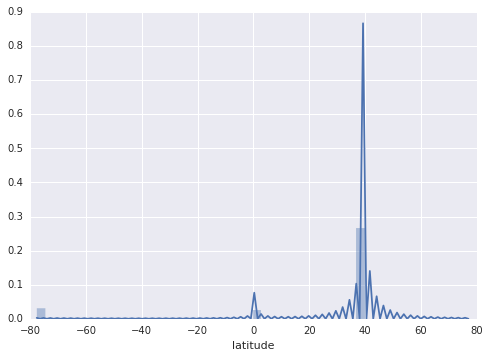

In [69]:
sns.distplot(dedup_stops.latitude) 
#sns.distp[['latitude','longitude']]

In [74]:
len(dedup_stops[dedup_stops.latitude < 30]), len(dedup_stops[dedup_stops.longitude>-60])

(85886, 85888)

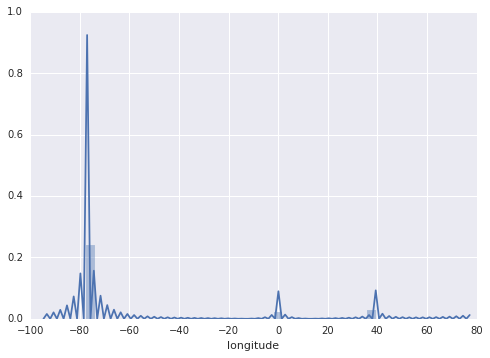

In [73]:
sns.distplot(dedup_stops.longitude) 
#sns.distp[['latitude','longitude']]

In [68]:
dedup_stops[dedup_stops.location.isnull()]

date_of_stop time_of_stop agency  \
562583  2013-08-30T00:00:00     23:39:00    MCP   

                                  subagency  \
562583  Headquarters and Special Operations   

                                              description location   latitude  \
562583  DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...     None  39.006675   

        longitude     vehicle_type  year         ...               model  \
562583  -77.07532  02 - Automobile  1997         ...          PATHFINDER   

       color violation_type   race gender driver_state driver_city dl_state  \
562583   RED       Citation  WHITE      M           MD    BETHESDA       MD   

            arrest_type                date  
562583  O - Foot Patrol 2013-08-30 23:39:00  

[1 rows x 21 columns]

In [75]:
dedup_stops.race.value_counts()

WHITE              200843
BLACK              140022
HISPANIC            82087
ASIAN               31948
OTHER               26809
NATIVE AMERICAN      1239
Name: race, dtype: int64

In [76]:
dedup_stops.gender.value_counts()

M    307369
F    174696
U       883
Name: gender, dtype: int64

In [77]:
dedup_stops.violation_type.value_counts()

Warning     253029
Citation    200925
ESERO        28498
SERO           496
Name: violation_type, dtype: int64

In [47]:
import seaborn as sns

In [78]:
pd.crosstab(dedup_stops.violation_type,dedup_stops.race)

race            ASIAN  BLACK  HISPANIC  NATIVE AMERICAN  OTHER   WHITE
violation_type                                                        
Citation        12696  57077     36541              427  10873   83311
ESERO            2052   8951      6881              110   1472    9032
SERO               25    157       123                1     21     169
Warning         17175  73837     38542              701  14443  108331

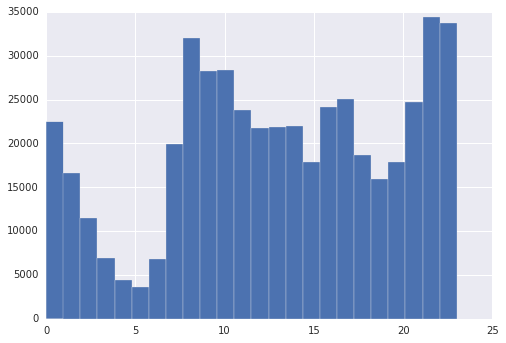

In [79]:
dedup_stops['date'].dt.hour.hist(bins=24)

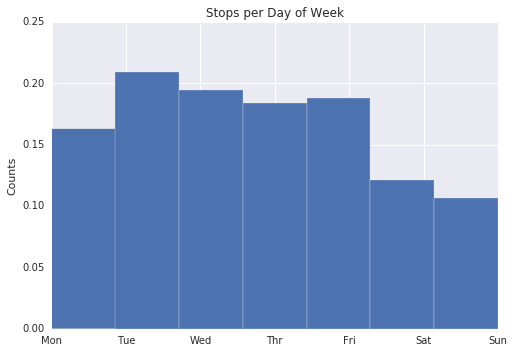

In [81]:
ax = dedup_stops.date.dt.weekday.hist(bins=7,normed=True)
ax.set_xticklabels(days_of_the_week)
plt.title('Stops per Day of Week')
plt.ylabel('Counts')

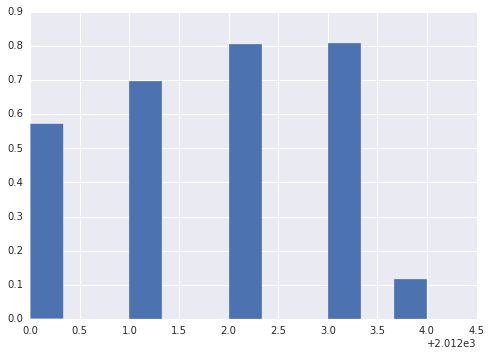

In [83]:
dedup_stops.date.dt.year.hist(bins=12,normed=True)

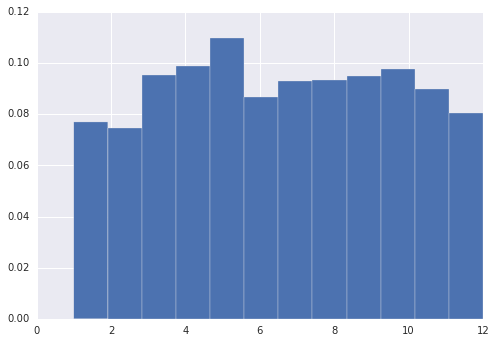

In [86]:
dedup_stops[(dedup_stops.date.dt.year>2012) & (dedup_stops.date.dt.year < 2016)].date.dt.month.hist(bins=12,normed=True)

In [85]:
dedup_stops.date.min(), dedup_stops.date.max()

(Timestamp('2012-01-01 00:43:00'), Timestamp('2016-03-02 23:56:00'))